<a href="https://colab.research.google.com/github/StevenMElliott/youtube-trending-classification/blob/master/YouTube_Trending_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install eli5 pdpbox category_encoders shap

In [0]:
from glob import glob
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier
import warnings
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.metrics import roc_auc_score, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score, validation_curve
from sklearn.model_selection import RandomizedSearchCV,  train_test_split
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import randint, uniform
from sklearn.impute import SimpleImputer
import eli5
from eli5.sklearn import PermutationImportance
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot


def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [0]:
import pandas as pd
import seaborn as sns

In [0]:
# Code to read csv file into Colaboratory:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
link = 'https://drive.google.com/open?id=1MvFD50qjGIOqDxVDrppEFMuxwBe901kG'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='

1MvFD50qjGIOqDxVDrppEFMuxwBe901kG


In [0]:
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('USvideos_modified.csv') 

In [7]:
link = 'https://drive.google.com/open?id=1JsoohUBiyzW9LfdXnwbG5DcvNWrkS4CF'
fluff, id = link.split('=')
print (id) # Verify that you have everything after '='
downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('Trending CrowdSourced Classification.csv') 

1JsoohUBiyzW9LfdXnwbG5DcvNWrkS4CF


In [8]:
df = pd.read_csv('USvideos_modified.csv')
df.head()

,video_id,last_trending_date,publish_date,publish_hour,category_id,channel_title,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,tag_appeared_in_title_count,tag_appeared_in_title,title,tags,description,trend_day_count,trend.publish.diff,trend_tag_highest,trend_tag_total,tags_count,subscriber
0,2kyS6SvSYSE,2017-11-20,2017-11-13,17,22,CaseyNeistat,2564903,96321,7972,22149,False,False,0,False,WE WANT TO TALK ABOUT OUR MARRIAGE,SHANtell martin,SHANTELL'S CHANNEL - https://www.youtube.com/s...,7,7,2,2,1,9086142.0
1,1ZAPwfrtAFY,2017-11-20,2017-11-13,7,24,LastWeekTonight,6109402,151250,11508,19820,False,False,0,False,The Trump Presidency: Last Week Tonight with J...,last week tonight trump presidency|last week t...,"One year after the presidential election, John...",7,7,65,69,4,5937292.0
2,5qpjK5DgCt4,2017-11-20,2017-11-12,19,23,Rudy Mancuso,5315471,187303,7278,9990,False,False,8,True,"Racist Superman | Rudy Mancuso, King Bach & Le...",racist superman|rudy|mancuso|king|bach|racist|...,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,7,8,68,426,23,4191209.0
3,puqaWrEC7tY,2017-11-20,2017-11-13,11,24,Good Mythical Morning,913268,16729,1386,2988,False,False,3,True,Nickelback Lyrics: Real or Fake?,rhett and link|gmm|good mythical morning|rhett...,Today we find out if Link is a Nickelback amat...,7,7,488,1246,28,13186408.0
4,d380meD0W0M,2017-11-19,2017-11-12,18,24,nigahiga,2819118,153395,2416,20573,False,False,1,True,I Dare You: GOING BALD!?,ryan|higa|higatv|nigahiga|i dare you|idy|rhpc|...,I know it's been a while since we did this sho...,6,7,488,1007,14,20563106.0


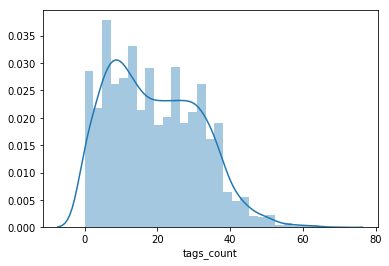

In [9]:
sns.distplot(df['tags_count'])

In [10]:
trend_class = pd.read_csv('Trending CrowdSourced Classification.csv')
t_class = trend_class.drop(['Unnamed: 2','Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5', 'Unnamed: 6'], axis=1)
t_class = t_class.dropna()
t_class = t_class.rename(columns={'channel': 'channel_title'})
t_class.head()

,channel_title,classification
0,Saturday Night Live,TM
1,CrazyRussianHacker,YT
2,20th Century Fox,TR
3,Vox,TM
4,NFL,TM


In [11]:
t_class['classification'].value_counts()

YT    812
TM    465
MU    409
CV    255
CO    170
TR     74
Name: classification, dtype: int64

In [0]:
youtuber = t_class[t_class['classification'] == 'YT']
traditional_media = t_class[t_class['classification'] =='TM']

In [0]:
tm_and_yt = pd.concat([youtuber, traditional_media])

In [14]:
tm_and_yt.shape
tm_and_yt['classification'].value_counts()

YT    812
TM    465
Name: classification, dtype: int64

In [0]:
t_class = df.merge(tm_and_yt, how='left')
# df_2.shape

In [0]:
# df_2.isnull().sum()

In [17]:
df = df.merge(t_class, how='left')
df.shape

(4547, 24)

In [18]:
df = df.drop(['video_id', 'last_trending_date', 'publish_date',
              'title', 'tags', 'description'], axis=1)
df.head()

,publish_hour,category_id,channel_title,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,tag_appeared_in_title_count,tag_appeared_in_title,trend_day_count,trend.publish.diff,trend_tag_highest,trend_tag_total,tags_count,subscriber,classification
0,17,22,CaseyNeistat,2564903,96321,7972,22149,False,False,0,False,7,7,2,2,1,9086142.0,YT
1,7,24,LastWeekTonight,6109402,151250,11508,19820,False,False,0,False,7,7,65,69,4,5937292.0,TM
2,19,23,Rudy Mancuso,5315471,187303,7278,9990,False,False,8,True,7,8,68,426,23,4191209.0,YT
3,11,24,Good Mythical Morning,913268,16729,1386,2988,False,False,3,True,7,7,488,1246,28,13186408.0,YT
4,18,24,nigahiga,2819118,153395,2416,20573,False,False,1,True,6,7,488,1007,14,20563106.0,YT


In [19]:
print(df.shape)
df.head(1)

(4547, 18)


,publish_hour,category_id,channel_title,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,tag_appeared_in_title_count,tag_appeared_in_title,trend_day_count,trend.publish.diff,trend_tag_highest,trend_tag_total,tags_count,subscriber,classification
0,17,22,CaseyNeistat,2564903,96321,7972,22149,False,False,0,False,7,7,2,2,1,9086142.0,YT


In [20]:
channels = df['channel_title'].unique()
len(channels)

1905

In [21]:
from sklearn.model_selection import train_test_split
train_chan, test_chan = train_test_split(channels, random_state=42)

train = df[df['channel_title'].isin(train_chan)]
test = df[df['channel_title'].isin(test_chan)]
assert(len(test) + len(train) == len(df))
test.shape, train.shape, df.shape

((1030, 18), (3517, 18), (4547, 18))

In [0]:
df.dropna();

In [23]:
#baseline
df['classification'].value_counts(normalize=True)

TM    0.512122
YT    0.487878
Name: classification, dtype: float64

In [0]:
def wrangle(X):
  
#   #to datetime
#   X['last_trending_date'] = pd.to_datetime(X['last_trending_date'], 
#                                            infer_datetime_format=True)
#   X['publish_date'] = pd.to_datetime(X['publish_date'], 
#                                      infer_datetime_format=True)
  
  #engagement column
  #note the +1's are to prevent dividing by 0 and ending the universe.
  X['engagement_level'] = X['views'] / (X['likes'] + 
                                        X['dislikes'] + 
                                        X['comment_count'] + 1)
  #possitive reception
  X['likes_perc'] = X['likes'] / (X['likes'] + 
                                  X['dislikes'] + 1)
  
  #hard engagement - How many comments are recieved vs likes/dislikes
  X['comments/doots'] = X['comment_count'] / (X['likes'] + 
                                             X['dislikes'] + 1)
  
  X = X.dropna()
  return(X)

wrangled_df = wrangle(df)
test = wrangle(test)
train = wrangle(train)

In [25]:
wrangled_df.head()

,publish_hour,category_id,channel_title,views,likes,dislikes,comment_count,comments_disabled,ratings_disabled,tag_appeared_in_title_count,tag_appeared_in_title,trend_day_count,trend.publish.diff,trend_tag_highest,trend_tag_total,tags_count,subscriber,classification,engagement_level,likes_perc,comments/doots
0,17,22,CaseyNeistat,2564903,96321,7972,22149,False,False,0,False,7,7,2,2,1,9086142.0,YT,20.285053,0.923553,0.212371
1,7,24,LastWeekTonight,6109402,151250,11508,19820,False,False,0,False,7,7,65,69,4,5937292.0,TM,33.461691,0.929288,0.121775
2,19,23,Rudy Mancuso,5315471,187303,7278,9990,False,False,8,True,7,8,68,426,23,4191209.0,YT,25.983375,0.962592,0.051341
3,11,24,Good Mythical Morning,913268,16729,1386,2988,False,False,3,True,7,7,488,1246,28,13186408.0,YT,43.274640,0.923438,0.164937
4,18,24,nigahiga,2819118,153395,2416,20573,False,False,1,True,6,7,488,1007,14,20563106.0,YT,15.982754,0.984488,0.132037


#Model Time!

In [0]:
target = 'classification'
y_train = train[target]
y_test = test[target]

In [27]:
!pip install category_encoders

In [0]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

In [0]:
train = train.dropna()
df.dropna()
test = test.dropna();

In [0]:
# The 'show_made_flag' column is the target
target = 'classification'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

# Arrange data into X features matrix and y target vector 
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]


In [31]:
categorical_features

['comments_disabled', 'ratings_disabled', 'tag_appeared_in_title']

In [32]:
df.isnull().sum()

publish_hour                      0
category_id                       0
channel_title                     0
views                             0
likes                             0
dislikes                          0
comment_count                     0
comments_disabled                 0
ratings_disabled                  0
tag_appeared_in_title_count       0
tag_appeared_in_title             0
trend_day_count                   0
trend.publish.diff                0
trend_tag_highest                 0
trend_tag_total                   0
tags_count                        0
subscriber                       22
classification                 1206
engagement_level                  0
likes_perc                        0
comments/doots                    0
dtype: int64

In [33]:
y_train = train['classification']
y_train.value_counts(normalize=True)

TM    0.525773
YT    0.474227
Name: classification, dtype: float64

In [0]:
majority_class = y_train.mode()[0]
y_pred = [majority_class] * len(y_train)

In [0]:
X_train.dropna();
y_train.dropna();

In [0]:

#Notice the Ordinal Encoding
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=1000, random_state=42, n_jobs=-1)
)

# Fit on train, score on val, predict on test
pipeline.fit(X_train, y_train);

In [37]:
pipeline.score(X_test, y_test)

0.7935393258426966

In [0]:
import matplotlib.pyplot as plt

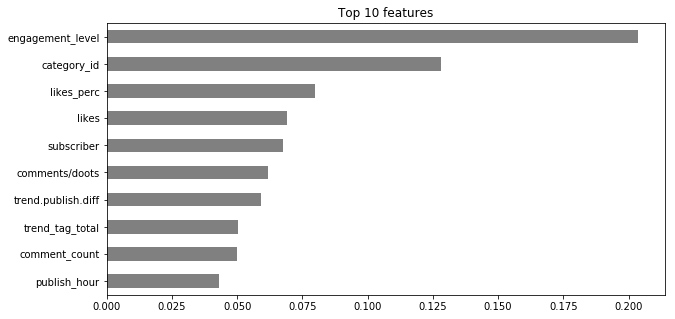

In [43]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot top 20 feature importances
n = 10
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [0]:
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred):
  labels = unique_labels(y_true)
  columns = [f'predicted {label}' for label in labels]
  index =[f'Actual {label}' for label in labels]
  table = pd.DataFrame(confusion_matrix(y_true, y_pred),
              columns=columns, index=index)
  return sns.heatmap(table, annot=True, fmt='d')

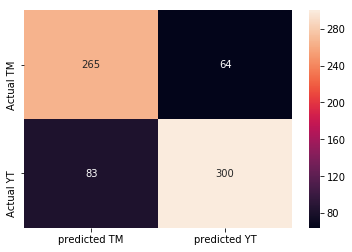

In [41]:
y_pred = pipeline.predict(X_test)
plot_confusion_matrix(y_test, y_pred);

In [44]:
from sklearn.metrics import classification_report
y_pred = pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          TM       0.76      0.81      0.78       329
          YT       0.82      0.78      0.80       383

    accuracy                           0.79       712
   macro avg       0.79      0.79      0.79       712
weighted avg       0.80      0.79      0.79       712

